## 1. 사용할 패키지 불러오기

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, plot_confusion_matrix
import torch.nn as nn
import torch.utils.data as data_utils
import torch

/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. 데이터 불러오기

In [3]:
data = pd.read_csv('maxdata2.csv')
data.head()

,ia,ib,ic,distance,location,type
0,25.921025,0.300361,0.153016,10,0,0
1,25.679561,0.299710,0.153383,20,0,0
2,25.442621,0.299341,0.153731,30,0,0
3,25.210031,0.298672,0.154085,40,0,0
4,24.981768,0.297860,0.154401,50,0,0


#### - 독립변수와 종속변수로 나누기

In [72]:
X = data.iloc[:, :3]
y_dist = data['distance']
y_Location = data['location']
y_Type = data['type']


## 3. XGBoost 모델 적합

### (1) Distance

#### - 학습 데이터 생성

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_dist, test_size=0.2, random_state=777)

#### - 하이퍼 파라미터 선정

In [6]:
n_estimators_candidate = [100, 200, 300,400,500, 1000]
max_depth_candidate = [3, 5, 7, 9]
learning_rate_candidate = [0.1, 0.01, 0.001, 0.0001]

# 결과를 저장할 빈 리스트 생성
n_estimators_list = []
max_depth_list = []
learning_rate_list = []
train_score_list = []
val_score_list = []

# XGBoost의 n_estimators 파라미터에 대해서
for n_estimators in n_estimators_candidate:
    # XGBoost의 max_depth 파라미터에 대해서
    for max_depth in max_depth_candidate:
        # XGBoost의 learning_rate 파라미터에 대해서
        for learning_rate in learning_rate_candidate:
            # 모델 생성 및 학습
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate).fit(X_train, y_train)
            # Train 데이터에 대한 결과 확인
            train_predict = model.predict(X_train)
            train_score_list.append(r2_score(y_train, train_predict))
            # Test 데이터에 대한 결과 확인
            test_predict = model.predict(X_test)
            val_score_list.append(r2_score(y_test, test_predict))
            # Parameter 저장
            n_estimators_list.append(n_estimators)
            max_depth_list.append(max_depth)
            learning_rate_list.append(learning_rate)
            
result = pd.DataFrame({"n_estimators": n_estimators_list, "max_depth": max_depth_list, "learning_rate": learning_rate_list, 'Train Score': train_score_list, 'Test Score': val_score_list})
result                    

,n_estimators,max_depth,learning_rate,Train Score,Test Score
0,100,3,0.1000,0.884182,0.891811
1,100,3,0.0100,-0.046929,-0.027004
2,100,3,0.0010,-2.407116,-2.386760
3,100,3,0.0001,-2.955247,-2.933775
4,100,5,0.1000,0.939326,0.930881
...,...,...,...,...,...
91,1000,7,0.0001,-2.338452,-2.317970
92,1000,9,0.1000,0.999976,0.898990
93,1000,9,0.0100,0.964604,0.926418
94,1000,9,0.0010,0.365060,0.376046


In [7]:
result = result.loc[result['Test Score'] == max(result['Test Score']), :].reset_index(drop = True)
result

,n_estimators,max_depth,learning_rate,Train Score,Test Score
0,500,9,0.01,0.944083,0.936299


In [8]:
model = xgb.XGBRegressor(n_estimators=result['n_estimators'][0], max_depth=result['max_depth'][0], learning_rate=result['learning_rate'][0], objective='reg:squarederror').fit(X_train, y_train)

#### - 성능 평가

In [9]:
train_predicted = model.predict(X_train)
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, train_predicted))))
print("Train R2 score: {}".format(r2_score(y_train, train_predicted)))

Train RMSE: 204.67805876071205
Train R2 score: 0.9440832044859171


In [35]:
test_predicted = model.predict(X_test)
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, test_predicted))))
print("Test R2 score: {}".format(r2_score(y_test, test_predicted)))

Test RMSE: 11.89420089459469
Test R2 score: 0.9998102185329695


### (2) Location

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_Location, test_size=0.2, random_state=777, stratify=y_Location) 

In [11]:
n_estimators_candidate = [100, 200, 300,400,500, 1000]
max_depth_candidate = [3, 5, 7, 9]
learning_rate_candidate = [0.1, 0.01, 0.001, 0.0001]

# 결과를 저장할 빈 리스트 생성
n_estimators_list = []
max_depth_list = []
learning_rate_list = []
train_score_list = []
val_score_list = []

# XGBoost의 n_estimators 파라미터에 대해서
for n_estimators in n_estimators_candidate:
    # XGBoost의 max_depth 파라미터에 대해서
    for max_depth in max_depth_candidate:
        # XGBoost의 learning_rate 파라미터에 대해서
        for learning_rate in learning_rate_candidate:
            # 모델 생성 및 학습
            model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate).fit(X_train, y_train)
            # Train 데이터에 대한 결과 확인
            train_predict = model.predict(X_train)
            train_score_list.append(accuracy_score(y_train, train_predict))
            # Test 데이터에 대한 결과 확인
            test_predict = model.predict(X_test)
            val_score_list.append(accuracy_score(y_test, test_predict))
            # Parameter 저장
            n_estimators_list.append(n_estimators)
            max_depth_list.append(max_depth)
            learning_rate_list.append(learning_rate)
            
result = pd.DataFrame({"n_estimators": n_estimators_list, "max_depth": max_depth_list, "learning_rate": learning_rate_list, 'Train Score': train_score_list, 'Test Score': val_score_list})
result                    

KeyboardInterrupt: 

In [38]:
result = result.loc[result['Test Score'] == max(result['Test Score']), :].reset_index(drop = True)
result

,n_estimators,max_depth,learning_rate,Train Score,Test Score
0,300,3,0.1,0.999167,1.0
1,400,3,0.1,0.999167,1.0
2,500,3,0.1,0.999167,1.0
3,1000,3,0.1,0.999167,1.0


In [39]:
model = xgb.XGBClassifier(n_estimators=result['n_estimators'][0], max_depth=result['max_depth'][0], learning_rate=result['learning_rate'][0], objective='reg:squarederror').fit(X_train, y_train)

#### - 학습 예측 결과

C:\Users\wook\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


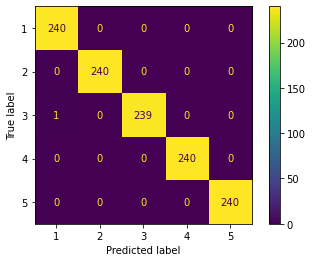

In [40]:
plot_confusion_matrix(model, X_train, y_train)

In [41]:
train_predicted = model.predict_proba(X_train)
train_predicted = np.argmax(train_predicted, axis = 1) + 1
print('Train Accuracy: {}'.format(accuracy_score(y_train, train_predicted)))

Train Accuracy: 0.9991666666666666


C:\Users\wook\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


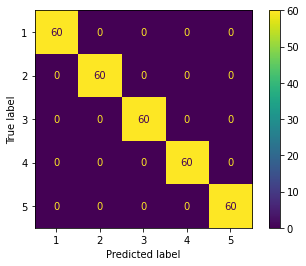

In [42]:
plot_confusion_matrix(model, X_test, y_test)

In [43]:
test_predicted = model.predict_proba(X_test)
test_predicted = np.argmax(test_predicted, axis = 1) + 1
print('Test Accuracy: {}'.format(accuracy_score(y_test, test_predicted)))

Test Accuracy: 1.0


### (3) Type

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
result = le.fit_transform(y_Type)

In [22]:
le.classes_

array([0, 4, 7, 8])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, result, test_size=0.2, random_state=777, stratify=y_Type) 

#### - 하이퍼 파라미터 튜닝

In [24]:
n_estimators_candidate = [100, 200, 300,400,500, 1000]
max_depth_candidate = [3, 5, 7, 9]
learning_rate_candidate = [0.1, 0.01, 0.001, 0.0001]

# 결과를 저장할 빈 리스트 생성
n_estimators_list = []
max_depth_list = []
learning_rate_list = []
train_score_list = []
val_score_list = []

# XGBoost의 n_estimators 파라미터에 대해서
for n_estimators in n_estimators_candidate:
    # XGBoost의 max_depth 파라미터에 대해서
    for max_depth in max_depth_candidate:
        # XGBoost의 learning_rate 파라미터에 대해서
        for learning_rate in learning_rate_candidate:
            # 모델 생성 및 학습
            model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate).fit(X_train, y_train)
            # Train 데이터에 대한 결과 확인
            train_predict = model.predict(X_train)
            train_score_list.append(accuracy_score(y_train, train_predict))
            # Test 데이터에 대한 결과 확인
            test_predict = model.predict(X_test)
            val_score_list.append(accuracy_score(y_test, test_predict))
            # Parameter 저장
            n_estimators_list.append(n_estimators)
            max_depth_list.append(max_depth)
            learning_rate_list.append(learning_rate)
            
result = pd.DataFrame({"n_estimators": n_estimators_list, "max_depth": max_depth_list, "learning_rate": learning_rate_list, 'Train Score': train_score_list, 'Test Score': val_score_list})
result                    

,n_estimators,max_depth,learning_rate,Train Score,Test Score
0,100,3,0.1000,1.0,1.0
1,100,3,0.0100,1.0,1.0
2,100,3,0.0010,1.0,1.0
3,100,3,0.0001,1.0,1.0
4,100,5,0.1000,1.0,1.0
...,...,...,...,...,...
91,1000,7,0.0001,1.0,1.0
92,1000,9,0.1000,1.0,1.0
93,1000,9,0.0100,1.0,1.0
94,1000,9,0.0010,1.0,1.0


In [25]:
result = result.loc[result['Test Score'] == max(result['Test Score']), :].reset_index(drop = True)
result

,n_estimators,max_depth,learning_rate,Train Score,Test Score
0,100,3,0.1000,1.0,1.0
1,100,3,0.0100,1.0,1.0
2,100,3,0.0010,1.0,1.0
3,100,3,0.0001,1.0,1.0
4,100,5,0.1000,1.0,1.0
...,...,...,...,...,...
91,1000,7,0.0001,1.0,1.0
92,1000,9,0.1000,1.0,1.0
93,1000,9,0.0100,1.0,1.0
94,1000,9,0.0010,1.0,1.0


In [26]:
model = xgb.XGBClassifier(n_estimators=result['n_estimators'][0], max_depth=result['max_depth'][0], learning_rate=result['learning_rate'][0], objective='reg:squarederror').fit(X_train, y_train)

#### - 학습 예측 결과

/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


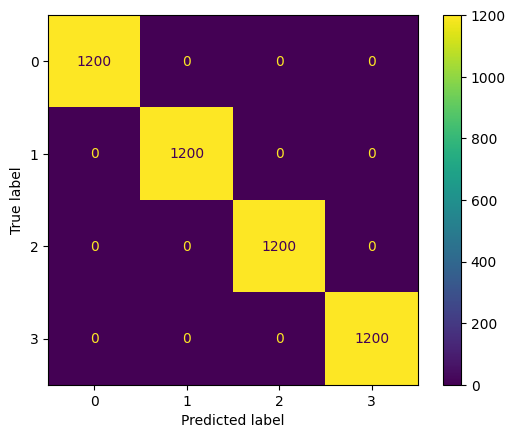

In [27]:
plot_confusion_matrix(model, X_train, y_train)

In [31]:
train_predicted = model.predict_proba(X_train)
train_predicted = np.argmax(train_predicted, axis = 1) 
print('Train Accuracy: {}'.format(accuracy_score(y_train, train_predicted)))

Train Accuracy: 1.0


/home/jongwook95.lee/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


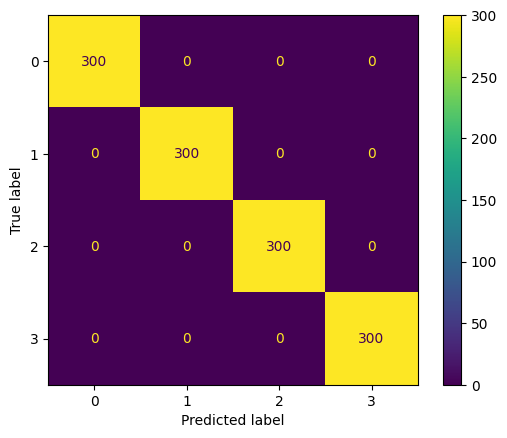

In [32]:
plot_confusion_matrix(model, X_test, y_test)

In [33]:
test_predicted = model.predict_proba(X_test)
test_predicted = np.argmax(test_predicted, axis = 1)
print('Test Accuracy: {}'.format(accuracy_score(y_test, test_predicted)))

Test Accuracy: 1.0


## 4. Multi-tasking 동시에 해결하기

### (1) Dataset 구성하기

In [73]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['type'] = le.fit_transform(data['type'])

In [74]:
y_multi = np.array(data.loc[:, ['distance', 'type']])

In [75]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
minmax_scaler = minmax_scaler.fit_transform(X)

In [76]:
label = y_multi[:,1]
one_hot = np.zeros((label.size, label.max() + 1))
one_hot[np.arange(label.size), label] = 1
y_multi_onehot = np.hstack((y_multi[:, [1,0]], one_hot))[:, 1:]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(minmax_scaler, y_multi_onehot, test_size=0.2, random_state=777, stratify=y_Type) 

In [83]:
class MyDataset(data_utils.Dataset):
 
    def __init__(self,X, y):
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]

In [84]:
train_dataset=MyDataset(np.array(X_train), np.array(y_train))
train_dataloader=data_utils.DataLoader(train_dataset,batch_size=64,shuffle=True)

In [85]:
test_dataset=MyDataset(np.array(X_test), np.array(y_test))
test_dataloader=data_utils.DataLoader(test_dataset,batch_size=64,shuffle=False)

### (2) Multi-Tasking Model 생성

In [86]:
from collections import OrderedDict
class Multi_tasking_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(OrderedDict([('linear1', nn.Linear(3,24)),('relu1', nn.ReLU()),('linear2', nn.Linear(24, 12)),('relu2', nn.ReLU()),('linear3', nn.Linear(12, 6)),('relu3', nn.ReLU())]))
        self.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(6,6)),('relu1', nn.ReLU()),('final', nn.Linear(6, 4)), ('softmax1', nn.Softmax(dim=1))]))
        
    def forward(self, x):
        feat = self.linear(x)
        cls_head = self.fc2(self.linear(x))
        return feat, cls_head

In [87]:
model = Multi_tasking_model()
model

Multi_tasking_model(
  (linear): Sequential(
    (linear1): Linear(in_features=3, out_features=24, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=24, out_features=12, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=12, out_features=6, bias=True)
    (relu3): ReLU()
  )
  (fc2): Sequential(
    (linear): Linear(in_features=6, out_features=6, bias=True)
    (relu1): ReLU()
    (final): Linear(in_features=6, out_features=4, bias=True)
    (softmax1): Softmax(dim=1)
  )
)

### (3) Loss와 Optimizer 구성

In [88]:
from torch.nn import (L1Loss, MSELoss, CrossEntropyLoss)
from torch.optim import Adam

In [89]:
# get loss function from LossFactory
loss_cls = CrossEntropyLoss()

# get optimizer from OptimizerFactory
optimizer = Adam(params = model.parameters(),
                 lr=0.01)

### (4) 학습

In [90]:
epoch = 300
min_loss = 10000000


for e in range(epoch):
    model.train()     # Optional when not using Model Specific layer
    for X,y in train_dataloader:
        X, y = X.float(), y.float()
        
        optimizer.zero_grad()
        feat, out_cls = model(X)
        true_label = torch.max(y[:, 1:],1).indices
        loss = loss_cls(out_cls, true_label)
        
        if loss < min_loss:
            torch.save(model, 'best_model.pt')
            min_loss = loss
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {e+1} \t Training Loss: {loss}')

print("Best Model`s loss: {}".format(min_loss))
model = torch.load('best_model.pt')

Epoch 1 	 Training Loss: 1.0226483345031738
Epoch 2 	 Training Loss: 0.7527530789375305
Epoch 3 	 Training Loss: 0.7462419867515564
Epoch 4 	 Training Loss: 0.7451454997062683
Epoch 5 	 Training Loss: 0.7440258264541626
Epoch 6 	 Training Loss: 0.7443406581878662
Epoch 7 	 Training Loss: 0.7438382506370544
Epoch 8 	 Training Loss: 0.7437936663627625
Epoch 9 	 Training Loss: 0.7437635064125061
Epoch 10 	 Training Loss: 0.7437570095062256
Epoch 11 	 Training Loss: 0.7438130378723145
Epoch 12 	 Training Loss: 0.7437107563018799
Epoch 13 	 Training Loss: 0.7437915205955505
Epoch 14 	 Training Loss: 0.7436989545822144
Epoch 15 	 Training Loss: 0.7437138557434082
Epoch 16 	 Training Loss: 0.7436816692352295
Epoch 17 	 Training Loss: 0.7437354326248169
Epoch 18 	 Training Loss: 0.7436992526054382
Epoch 19 	 Training Loss: 0.7436804175376892
Epoch 20 	 Training Loss: 0.7436943650245667
Epoch 21 	 Training Loss: 0.7436898350715637
Epoch 22 	 Training Loss: 0.7436911463737488
Epoch 23 	 Training

### (5) Regression Feature 추출

In [91]:
feat_list = []
y_list = []
train_location_true = []
train_location_pred = []

with torch.no_grad():  
    for X,y in train_dataloader:
        X, y = X.float(), y.float()
        feat, out_cls = model(X)
        feat_list.append(feat.numpy())
        y_list = y_list + list(y[:, 0].numpy())
        true_label = torch.max(y[:, 1:],1).indices
        pred_label = torch.max(out_cls,1).indices
        train_location_true = train_location_true + list(true_label.numpy())
        train_location_pred = train_location_pred + list(pred_label.numpy())

In [92]:
X_train = np.vstack(feat_list)
y_train = np.array(y_list)

In [93]:
feat_list = []
y_list = []
test_type_true = []
test_type_pred = []


with torch.no_grad():  
    for X,y in test_dataloader:
        X, y = X.float(), y.float()
        feat, out_cls = model(X)
        feat_list.append(feat.numpy())
        y_list = y_list + list(y[:, 0].numpy())
        true_label = torch.max(y[:, 1:],1).indices
        pred_label = torch.max(out_cls,1).indices
        test_type_true = test_type_true + list(true_label.numpy())
        test_type_pred = test_type_pred + list(pred_label.numpy())

In [94]:
X_test = np.vstack(feat_list)
y_test = np.array(y_list)

In [95]:
n_estimators_candidate = [100, 200, 300,400,500, 1000]
max_depth_candidate = [3, 5, 7, 9]
learning_rate_candidate = [0.1, 0.01, 0.001, 0.0001]

# 결과를 저장할 빈 리스트 생성
n_estimators_list = []
max_depth_list = []
learning_rate_list = []
train_score_list = []
val_score_list = []

# XGBoost의 n_estimators 파라미터에 대해서
for n_estimators in n_estimators_candidate:
    # XGBoost의 max_depth 파라미터에 대해서
    for max_depth in max_depth_candidate:
        # XGBoost의 learning_rate 파라미터에 대해서
        for learning_rate in learning_rate_candidate:
            # 모델 생성 및 학습
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate).fit(X_train, y_train)
            # Train 데이터에 대한 결과 확인
            train_predict = model.predict(X_train)
            train_score_list.append(r2_score(y_train, train_predict))
            # Test 데이터에 대한 결과 확인
            test_predict = model.predict(X_test)
            val_score_list.append(r2_score(y_test, test_predict))
            # Parameter 저장
            n_estimators_list.append(n_estimators)
            max_depth_list.append(max_depth)
            learning_rate_list.append(learning_rate)
            
result = pd.DataFrame({"n_estimators": n_estimators_list, "max_depth": max_depth_list, "learning_rate": learning_rate_list, 'Train Score': train_score_list, 'Test Score': val_score_list})
result                    

,n_estimators,max_depth,learning_rate,Train Score,Test Score
0,100,3,0.1000,0.734452,0.723958
1,100,3,0.0100,-0.164575,-0.116767
2,100,3,0.0010,-2.469560,-2.307010
3,100,3,0.0001,-2.992666,-2.809048
4,100,5,0.1000,0.827768,0.780228
...,...,...,...,...,...
91,1000,7,0.0001,-2.417324,-2.249340
92,1000,9,0.1000,0.999703,0.688088
93,1000,9,0.0100,0.901236,0.770218
94,1000,9,0.0010,0.187541,0.239986


In [96]:
result = result.loc[result['Test Score'] == max(result['Test Score']), :].reset_index(drop = True)
result

,n_estimators,max_depth,learning_rate,Train Score,Test Score
0,500,7,0.01,0.83146,0.781747


In [97]:
model = xgb.XGBRegressor(n_estimators=result['n_estimators'][0], max_depth=result['max_depth'][0], learning_rate=result['learning_rate'][0], objective='reg:squarederror').fit(X_train, y_train)

In [98]:
train_predicted = model.predict(X_train)
test_predicted = model.predict(X_test)

In [99]:
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, train_predicted))))
print("Train R2 score: {}".format(r2_score(y_train, train_predicted)))
print('Train Accuracy: {}'.format(accuracy_score(train_location_true, train_location_pred)))

Train RMSE: 354.6826477050781
Train R2 score: 0.8314595429623566
Train Accuracy: 1.0


In [100]:
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, test_predicted))))
print("Test R2 score: {}".format(r2_score(y_test, test_predicted)))
print('Test Accuracy: {}'.format(accuracy_score(test_type_true, test_type_pred)))

Test RMSE: 408.2412109375
Test R2 score: 0.7817466315740985
Test Accuracy: 1.0
